In [1]:
from collections import defaultdict
import numpy as np
import sympy
import matplotlib.pyplot as plt
import chempy
from chempy import Reaction, Substance, ReactionSystem
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.analysis import plot_reaction_contributions
from chempy.printing.tables import UnimolecularTable, BimolecularTable
import pyodesys
from pyodesys.symbolic import ScaledSys
from pyneqsys.plotting import mpl_outside_legend
sympy.init_printing()
%matplotlib inline
{k: globals()[k].__version__ for k in 'sympy pyodesys chempy'.split()}

{'sympy': '1.9', 'pyodesys': '0.14.1', 'chempy': '0.8.2'}

In [2]:
# Never mind the next row, it contains all the reaction data of aqueous radiolysis at room temperature
_species, _reactions = ['H', 'H+', 'H2', 'e-(aq)', 'HO2-', 'HO2', 'H2O2', 'HO3', 'O-', 'O2', 'O2-', 'O3', 'O3-', 'OH', 'OH-', 'H2O'], [({1: 1, 14: 1}, {15: 1}, 140000000000.0, {}), ({15: 1}, {1: 1, 14: 1}, 2.532901323662559e-05, {}), ({6: 1}, {1: 1, 4: 1}, 0.11193605692841689, {}), ({1: 1, 4: 1}, {6: 1}, 50000000000.0, {}), ({6: 1, 14: 1}, {4: 1, 15: 1}, 13000000000.0, {}), ({4: 1, 15: 0}, {6: 1, 14: 1}, 58202729.542927094, {15: 1}), ({3: 1, 15: 0}, {0: 1, 14: 1}, 19.0, {15: 1}), ({0: 1, 14: 1}, {3: 1, 15: 1}, 18000000.0, {}), ({0: 1}, {1: 1, 3: 1}, 3.905960400662016, {}), ({1: 1, 3: 1}, {0: 1}, 23000000000.0, {}), ({13: 1, 14: 1}, {8: 1, 15: 1}, 13000000000.0, {}), ({8: 1, 15: 0}, {13: 1, 14: 1}, 103500715.55425139, {15: 1}), ({13: 1}, {8: 1, 1: 1}, 0.12589254117941662, {}), ({8: 1, 1: 1}, {13: 1}, 100000000000.0, {}), ({5: 1}, {1: 1, 10: 1}, 1345767.401963457, {}), ({1: 1, 10: 1}, {5: 1}, 50000000000.0, {}), ({5: 1, 14: 1}, {10: 1, 15: 1}, 50000000000.0, {}), ({10: 1, 15: 0}, {5: 1, 14: 1}, 18.619585312728415, {15: 1}), ({3: 1, 13: 1}, {14: 1}, 30000000000.0, {}), ({3: 1, 6: 1}, {13: 1, 14: 1}, 14000000000.0, {}), ({10: 1, 3: 1, 15: 0}, {4: 1, 14: 1}, 13000000000.0, {15: 1}), ({3: 1, 5: 1}, {4: 1}, 20000000000.0, {}), ({9: 1, 3: 1}, {10: 1}, 22200000000.0, {}), ({3: 2, 15: 0}, {2: 1, 14: 2}, 5000000000.0, {15: 2}), ({0: 1, 3: 1, 15: 0}, {2: 1, 14: 1}, 25000000000.0, {15: 1}), ({3: 1, 4: 1}, {8: 1, 14: 1}, 3500000000.0, {}), ({8: 1, 3: 1, 15: 0}, {14: 2}, 22000000000.0, {15: 1}), ({3: 1, 12: 1, 15: 0}, {9: 1, 14: 2}, 16000000000.0, {15: 1}), ({3: 1, 11: 1}, {12: 1}, 36000000000.0, {}), ({0: 1, 15: 0}, {2: 1, 13: 1}, 11.0, {15: 1}), ({0: 1, 8: 1}, {14: 1}, 10000000000.0, {}), ({0: 1, 4: 1}, {13: 1, 14: 1}, 90000000.0, {}), ({0: 1, 12: 1}, {9: 1, 14: 1}, 10000000000.0, {}), ({0: 2}, {2: 1}, 7750000000.0, {}), ({0: 1, 13: 1}, {15: 1}, 7000000000.0, {}), ({0: 1, 6: 1}, {13: 1, 15: 1}, 90000000.0, {}), ({0: 1, 9: 1}, {5: 1}, 21000000000.0, {}), ({0: 1, 5: 1}, {6: 1}, 10000000000.0, {}), ({0: 1, 10: 1}, {4: 1}, 20000000000.0, {}), ({0: 1, 11: 1}, {7: 1}, 38000000000.0, {}), ({13: 2}, {6: 1}, 3600000000.0, {}), ({5: 1, 13: 1}, {9: 1, 15: 1}, 6000000000.0, {}), ({10: 1, 13: 1}, {9: 1, 14: 1}, 8200000000.0, {}), ({2: 1, 13: 1}, {0: 1, 15: 1}, 40000000.0, {}), ({13: 1, 6: 1}, {5: 1, 15: 1}, 30000000.0, {}), ({8: 1, 13: 1}, {4: 1}, 20000000000.0, {}), ({4: 1, 13: 1}, {5: 1, 14: 1}, 7500000000.0, {}), ({12: 1, 13: 1}, {11: 1, 14: 1}, 2550000000.0, {}), ({12: 1, 13: 1}, {1: 1, 10: 2}, 5950000000.0, {}), ({11: 1, 13: 1}, {9: 1, 5: 1}, 110000000.0, {}), ({10: 1, 5: 1}, {9: 1, 4: 1}, 80000000.0, {}), ({5: 2}, {9: 1, 6: 1}, 800000.0, {}), ({8: 1, 5: 1}, {9: 1, 14: 1}, 6000000000.0, {}), ({5: 1, 6: 1}, {9: 1, 13: 1, 15: 1}, 0.5, {}), ({4: 1, 5: 1}, {9: 1, 13: 1, 14: 1}, 0.5, {}), ({12: 1, 5: 1}, {9: 2, 14: 1}, 6000000000.0, {}), ({11: 1, 5: 1}, {9: 1, 7: 1}, 500000000.0, {}), ({10: 2, 15: 0}, {9: 1, 6: 1, 14: 2}, 100.0, {15: 2}), ({8: 1, 10: 1, 15: 0}, {9: 1, 14: 2}, 600000000.0, {15: 1}), ({10: 1, 6: 1}, {9: 1, 13: 1, 14: 1}, 0.13, {}), ({10: 1, 4: 1}, {8: 1, 9: 1, 14: 1}, 0.13, {}), ({10: 1, 12: 1, 15: 0}, {9: 2, 14: 2}, 10000.0, {15: 1}), ({10: 1, 11: 1}, {9: 1, 12: 1}, 1500000000.0, {}), ({8: 2, 15: 0}, {4: 1, 14: 1}, 1000000000.0, {15: 1}), ({8: 1, 9: 1}, {12: 1}, 3600000000.0, {}), ({8: 1, 2: 1}, {0: 1, 14: 1}, 80000000.0, {}), ({8: 1, 6: 1}, {10: 1, 15: 1}, 500000000.0, {}), ({8: 1, 4: 1}, {10: 1, 14: 1}, 400000000.0, {}), ({8: 1, 12: 1}, {10: 2}, 700000000.0, {}), ({8: 1, 11: 1}, {9: 1, 10: 1}, 5000000000.0, {}), ({12: 1}, {8: 1, 9: 1}, 300.0, {}), ({1: 1, 12: 1}, {9: 1, 13: 1}, 90000000000.0, {}), ({12: 1, 6: 1}, {9: 1, 10: 1, 15: 1}, 1600000.0, {}), ({12: 1, 4: 1}, {9: 1, 10: 1, 14: 1}, 890000.0, {}), ({2: 1, 12: 1}, {0: 1, 9: 1, 14: 1}, 250000.0, {}), ({7: 1}, {9: 1, 13: 1}, 110000.0, {}), ({13: 1, 7: 1}, {9: 1, 6: 1}, 5000000000.0, {}), ({7: 2}, {9: 2, 6: 1}, 5000000000.0, {}), ({10: 1, 7: 1}, {9: 2, 14: 1}, 10000000000.0, {}), ({7: 1}, {1: 1, 12: 1}, 328.097819129701, {}), ({1: 1, 12: 1}, {7: 1}, 52000000000.0, {}), ({11: 1, 14: 1}, {10: 1, 5: 1}, 70.0, {}), ({11: 1, 4: 1}, {9: 1, 10: 1, 13: 1}, 2800000.0, {})]

In [3]:
species = [Substance.from_formula(s) for s in _species]
reactions = [
    Reaction({_species[k]: v for k, v in reac.items()},
             {_species[k]: v for k, v in prod.items()}, param,
             {_species[k]: v for k, v in inact_reac.items()})
    for reac, prod, param, inact_reac in _reactions
]

In [4]:
# radiolytic yields for gamma radiolysis of neat water
C_H2O = 55.5
YIELD_CONV = 1.0364e-07 # mol * eV / (J * molecules)
prod_rxns = [
    Reaction({'H2O': 1}, {'H+': 1,  'OH-': 1},            0.5  * YIELD_CONV / C_H2O),
    Reaction({'H2O': 1}, {'H+': 1, 'e-(aq)': 1, 'OH': 1}, 2.6  * YIELD_CONV / C_H2O),
    Reaction({'H2O': 1}, {'H':  2, 'H2O2': 1},            0.66 * YIELD_CONV / C_H2O, {'H2O': 1}),
    Reaction({'H2O': 1}, {'H2': 1, 'H2O2': 1},            0.74 * YIELD_CONV / C_H2O, {'H2O': 1}),
    Reaction({'H2O': 1}, {'H2': 1,   'OH': 2},            0.1  * YIELD_CONV / C_H2O, {'H2O': 1}),
    Reaction({'H2O': 1}, {'H2': 3,  'HO2': 2},            0.04 * YIELD_CONV / C_H2O, {'H2O': 3}),
]

In [5]:
# The productions reactions have hardcoded rates corresponding to 1 Gy/s
rsys = ReactionSystem(prod_rxns + reactions, species)
rsys

In [6]:
uni, not_uni = UnimolecularTable.from_ReactionSystem(rsys)
bi, not_bi = BimolecularTable.from_ReactionSystem(rsys)
assert not (not_uni & not_bi), "There are only uni- & bi-molecular reactions in this set"

In [7]:
uni

H,"3.905960400662016, 11.0"
H+,
H2,
e-(aq),19.0
HO2-,58202729.542927094
HO2,1345767.401963457
H2O2,0.11193605692841689
HO3,"110000.0, 328.097819129701"
O-,103500715.55425139
O2,
O2-,18.619585312728415


In [8]:
bi

H,7750000000.0,,,25000000000.0,90000000.0,10000000000.0,90000000.0,,10000000000.0,21000000000.0,20000000000.0,38000000000.0,10000000000.0,7000000000.0,18000000.0,
H+,-,,,23000000000.0,50000000000.0,,,,100000000000.0,,50000000000.0,,"90000000000.0, 52000000000.0",,140000000000.0,
H2,-,-,,,,,,,80000000.0,,,,250000.0,40000000.0,,
e-(aq),-,-,-,5000000000.0,3500000000.0,20000000000.0,14000000000.0,,22000000000.0,22200000000.0,13000000000.0,36000000000.0,16000000000.0,30000000000.0,,
HO2-,-,-,-,-,,0.5,,,400000000.0,,0.13,2800000.0,890000.0,7500000000.0,,
HO2,-,-,-,-,-,800000.0,0.5,,6000000000.0,,80000000.0,500000000.0,6000000000.0,6000000000.0,50000000000.0,
H2O2,-,-,-,-,-,-,,,500000000.0,,0.13,,1600000.0,30000000.0,13000000000.0,
HO3,-,-,-,-,-,-,-,5000000000.0,,,10000000000.0,,,5000000000.0,,
O-,-,-,-,-,-,-,-,-,1000000000.0,3600000000.0,600000000.0,5000000000.0,700000000.0,20000000000.0,,
O2,-,-,-,-,-,-,-,-,-,,,,,,,
O2-,-,-,-,-,-,-,-,-,-,-,100.0,1500000000.0,10000.0,8200000000.0,,


In [9]:
odesys, extra = get_odesys(rsys)
odesys.exprs[:3]  # take a look at the first three ODEs in the system

/Volumes/MacBuckBook/opt/anaconda3/lib/python3.9/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_png function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/Volumes/MacBuckBook/opt/anaconda3/lib/python3.9/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_rgba function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/Volumes/MacBuckBook/opt/anaconda3/lib/python3.9/site-packages/IPython/lib/latextools.py:126: MatplotlibDeprecationWarning: 
The to_mask function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use mathtext.math_to_image instead.
  mt.to_png(f, s, fontsize=12, dpi=dpi, color=color)
/Volumes/MacBuckBook/opt/anaconda3/lib/python3.9/site-packa

In [10]:
j = odesys.get_jac()
j.shape

In [11]:
def integrate_and_plot(odesys, c0_dict, integrator, ax=None, zero_conc=0, log10_t0=-12, tout=None,
                       print_info=False, **kwargs):
    if tout is None:
        tout = np.logspace(log10_t0, 6)
    c0 = [c0_dict.get(k, zero_conc)+zero_conc for k in _species]
    result = odesys.integrate(tout, c0, integrator=integrator, **kwargs)
    if ax is None:
        ax = plt.subplot(1, 1, 1)
    result.plot(ax=ax, title_info=2)
    ax.set_xscale('log'); ax.set_yscale('log')
    mpl_outside_legend(ax, prop={'size': 9})
    if print_info:
        print({k: v for k, v in result.info.items() if not k.startswith('internal')})
    return result

DEBUG:matplotlib.ticker:vmin 1.2589254117941663e-13 vmax 7943282.347242822
DEBUG:matplotlib.ticker:ticklocs array([1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-04, 1.e-01, 1.e+02, 1.e+05,
       1.e+08, 1.e+11])
DEBUG:matplotlib.ticker:vmin 1e-16 vmax 60.0
DEBUG:matplotlib.ticker:ticklocs array([1.e-19, 1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-04, 1.e-01, 1.e+02,
       1.e+05])
DEBUG:matplotlib.ticker:vmin 1.2589254117941663e-13 vmax 7943282.347242822
DEBUG:matplotlib.ticker:ticklocs array([1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-04, 1.e-01, 1.e+02, 1.e+05,
       1.e+08, 1.e+11])
DEBUG:matplotlib.ticker:vmin 1.2589254117941663e-13 vmax 7943282.347242822
DEBUG:matplotlib.ticker:ticklocs array([1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-04, 1.e-01, 1.e+02, 1.e+05,
       1.e+08, 1.e+11])
DEBUG:matplotlib.ticker:vmin 1.2589254117941663e-13 vmax 7943282.347242822
DEBUG:matplotlib.ticker:vmin 1.2589254117941663e-13 vmax 7943282.347242822
DEBUG:matplotlib.ticker:ticklocs array([1.e-16, 1.e-13, 1.e-10, 1.e-07, 1.e-

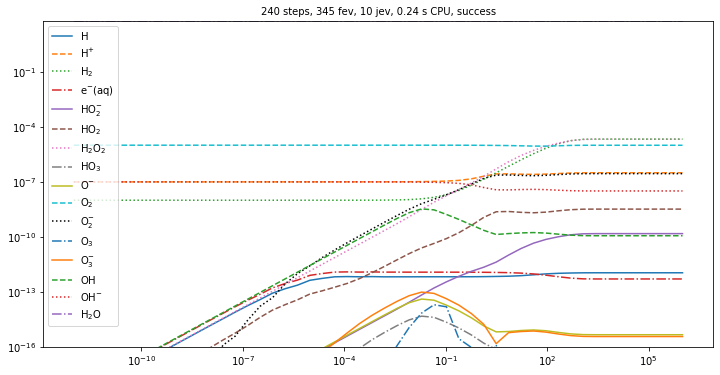

In [31]:
c0_dict = defaultdict(float, {'H+': 1e-7, 'OH-': 1e-7, 'O2': 1e-5, 'H2': 1e-8, 'H2O': 55.5})
plt.figure(figsize=(16,6))
integrate_and_plot(odesys, c0_dict, integrator='cvode', first_step=1e-14, atol=1e-10, rtol=1e-10, autorestart=5)
plt.legend()
_ = plt.ylim([1e-16, 60])